<a href="https://colab.research.google.com/github/dongzooo/Text-Sentiment-Analysis-ML/blob/main/3__Sentiment_Analysis_Naive_Bayes_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 나이브 베이지 모델링 : 감성분석 분류기 모델

In [ ]:
import pandas as pd
import numpy as np
import csv
from konlpy.tag import Okt
from collections import Counter
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib as Path
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
okt = Okt()
# 라벨링된 텍스트 데이터 파일 읽기
df = pd.read_csv("movieReviewDataset.csv")
# 리뷰/라벨링 데이터만 추출해서 리스트로 변환한 다음 reviews/labels에 저장
df.columns = ['label','review']
reviews = df['review'].values.tolist()
labels = df['label'].values.tolist()

## EDA

In [ ]:
#파일 확인
df.head()

,label,review
0,0,퀄리티가 장난 아니게 좋았어요 진짜 재밌는데 왜 그렇게 까 내리는지 모르겠음 ㅠㅠ...
1,0,재미나요 이 정도면 ㅋㅋ 딱 보기 좋아요
2,0,2시간 37분 지겹지 않게 봤어요 이랑보다는 재미있습니다 솔직한 평임 미션도 엄청...
3,0,1편보다 그 이상 짜임새도 있고 재미도 뛰어난 한국 영화 정말 오랜만입니다 처음부...
4,0,다음 편이 기대돼요 잘 봤습니다 반전에 반전이 대박이었다 1편보다 더 꿀 잼임 꼭...


In [ ]:
# information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2398 entries, 0 to 2397
Data columns (total 2 columns):
label     2398 non-null int64
review    2398 non-null object
dtypes: int64(1), object(1)
memory usage: 37.5+ KB


In [ ]:
# dimension
df.shape

(2398, 2)

In [ ]:
# 결측치
df.isnull().sum()

label     0
review    0
dtype: int64

In [ ]:
#정규 표현식 함수 정의
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [ ]:
# 명사 형태소 추출 함수
nouns = []
for i in range(0,2990):
    temp = okt.nouns(apply_regular_expression(df['review'][i]))
    for j in range(len(temp)):
        nouns.append(temp[j])
    
print(nouns)

['퀄리티', '장난', '진짜', '왜', '기대', '이상', '정말', '재미', '재미나', '이', '정도', '보기', '시간', '분', '이', '평임', '미션', '신', '평점', '듯', '잼', '편', '더', '재미', '남', '점', '준', '사람', '그로', '임', '꼭', '편', '몰입도', '그냥', '짐', '천만', '영화', '미리', '축하', '기대', '영화', '편', '그', '이상', '짜임새', '재미', '한국', '영화', '정말', '처음', '끝', '감동', '정말', '주지훈', '정말', '최고', '인생', '띵작', '꼭', '영화', '진짜', '개꿀', '잼', '반전', '잠시', '사후', '삶', '가치', '영화', '몰입', '감', '상미', '더위', '볼거리', '편', '스토리', '오히려', '더', '짜임새', '더', '다음', '편이', '기대', '반전', '반전', '대박', '편', '더', '꿀', '잼임', '꼭', '누가', '뭐', '도', '저', '주지훈', '치', '주지훈', '씨', '때문', '계속', '웃', '수', '영화', '전작', '모성애', '이번', '부', '애', '수', '반전', '진짜', '개', '반전', '소름', '주지훈', '도경수', '졸귀', '또', '편', '훨', '펀드', '반드시', '다음', '편이', '기대', '편', '덜', '내용', '더', '아다리', '느낌', '반전', '굿', '무조건', '알바', '랰', '전', '보고', '처음', '좀', '진행', '일편', '별로', '이번', '편', '꿀', '잼임', '초반', '거', '첨부', '터', '집중', '봄', '주지훈', '개', '존', '이', '정도', '주지훈', '진심', '대박', '머리', '때', '소리', '뻔', '훈', '영화', '편', '재미', '남', '마지막', '정말', '인상',

In [ ]:
# 명사 빈도 탐색
counter = Counter(nouns)
available_counter = Counter({x: counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('영화', 1649),
 ('진짜', 358),
 ('보고', 317),
 ('정말', 237),
 ('반전', 221),
 ('사람', 199),
 ('생각', 186),
 ('스토리', 162),
 ('기대', 161),
 ('그냥', 157)]

Text(0, 0.5, 'number of frequency')

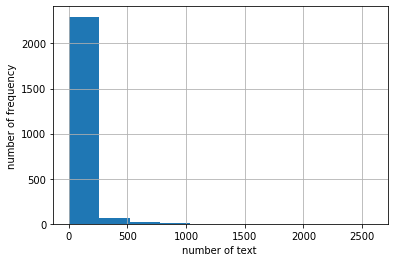

In [ ]:
#영화리뷰의 글자 수 히스토그램 
ax = df['review'].str.len().hist() 
ax.set_xlabel('number of text ') 
ax.set_ylabel('number of frequency')

Text(0, 0.5, 'number of frequency')

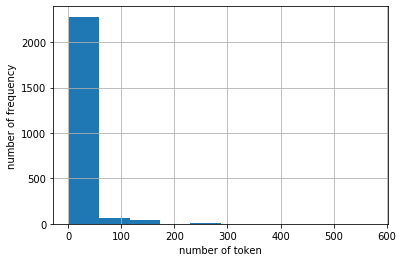

In [ ]:
#토큰 수 
ax = df['review'].str.split().map(lambda x: len(x)).hist() 
ax.set_xlabel('number of token') 
ax.set_ylabel('number of frequency')

Text(0, 0.5, 'number of frequency')

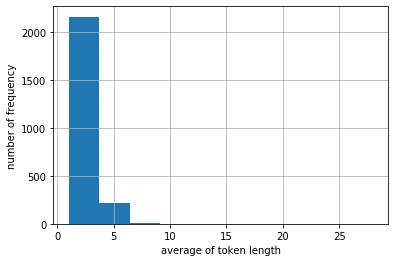

In [ ]:
#토큰별 길이 평균
ax = df['review'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist() 
ax.set_xlabel('average of token length')
ax.set_ylabel('number of frequency')


## 나이브베이즈 모델링

In [ ]:
# 훈련 데이터와 테스트 데이터 60%와 40%로 분리
train_x, test_x, train_y, test_y = train_test_split(
    labels, reviews, test_size=0.4, random_state=0)
print("train : test = 6 : 4")

train : test = 6 : 4


In [ ]:
# 불용어 사전 불러오기
stop = pd.read_csv("stop_words.csv", encoding='utf-8-sig')
stop_words = stop['0'].values.tolist()

In [ ]:
# 정제된 훈련용 리뷰 데이터 저장용
settled_train = []
# 온점(.) 제거 및 토큰화
for train in train_y:
    # 불용어 사전에 온점(.)도 넣어놔서 바로 아래 코드는 아마도 필요 없을듯
    # train = re.sub("(\.)", "", str(train))
    train = okt.pos(train, stem=True)
    trained = ''
    for i in range(len(train)):
        # 불용어 제거
        if train[i][0] not in stop_words:
            trained = trained + ' ' + train[i][0]
    # 오류가 날 수 있음, 일단 주석처리
#     if trained != '':
#         settled_train.append(trained)
    settled_train.append(trained)
# 결과적으로 train_y -> settled_train
# 토큰화 결과 예) "나는 밥을 먹는다." -> "나 밥 먹다"

In [ ]:
#텍스트 벡터화
vectorizer = CountVectorizer()
#독립적인 배열이 된 txt텍스트를 백터화된 텍스트 변수에 fit_transform
counts = vectorizer.fit_transform(settled_train)

In [ ]:
#가중치 설정
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(counts)

In [ ]:
#모델 선언
clf = MultinomialNB()
clf.fit(tfidfv, train_x)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# 테스트 데이터 정제
settled_test = []
for test in test_y:
    # test = re.sub("(\.)", "", str(test))
    test = okt.pos(test, stem=True)
    tested = ''
    for i in range(len(test)):
        if test[i][0] not in stop_words:
            tested = tested + ' ' + test[i][0]
    # if tested != '':
    #     settled_test.append(tested)
    settled_test.append(tested)

In [ ]:
test_counts = vectorizer.transform(settled_test)
tfidfv_test = tfidf_transformer.transform(test_counts)

In [ ]:
#정확도 예측
predicted = clf.predict(tfidfv_test)  # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(test_x, predicted))  # 예측값과 실제값 비교

정확도: 0.7197916666666667


In [ ]:
#감성분석 분류 리스트
sen = ['기쁨', '기대', '놀람', ' 공포', '분노', '슬픔']

In [ ]:
#텍스트 감정분류가 잘되는 지 직접 데스트 데이터 구현
text_data = ['오늘 너무 즐거운 하루였다. 맛있는 음식을 먹고 날씨가 너무 좋았다.',
'하지만 갑자기 비가와서 기분이 우울하고 진짜 짜증났다.',
'게다가 집에 거미가 나와서 깜짝 놀랐다',
'오늘 영화도 봤는데  요 근래에 본 공포영화들 중에서 제일 오싹오싹했다',
'다음에는 가슴이 설레는 로맨스 영화도 한번보며 웃고 싶다.']

In [ ]:
print('----직접 작성해본 데이터 감성 분류 결과----')
for i in text_data:
    temp = np.array([i]) #텍스트 데이터 수치화
    temp_vector = vectorizer.transform(temp) #vectorizer로 변환
    emo_num = int(clf.predict(temp_vector)) # 예측
    print(i,'->',sen[emo_num])

----직접 작성해본 데이터 감성 분류 결과----
오늘 너무 즐거운 하루였다. 맛있는 음식을 먹고 날씨가 너무 좋았다. -> 기쁨
하지만 갑자기 비가와서 기분이 우울하고 진짜 짜증났다. -> 분노
게다가 집에 거미가 나와서 깜짝 놀랐다 -> 놀람
오늘 영화도 봤는데  요 근래에 본 공포영화들 중에서 제일 오싹오싹했다 ->  공포
다음에는 가슴이 설레는 로맨스 영화도 한번보며 웃고 싶다. -> 기대
